# <center> BBM409 : Introduction to Machine Learning Lab. </center>
## <center> Assignment 2 </center>

![alt_text](https://www.nokia.com/sites/default/files/styles/nokia_blog_page_image/public/blog/nokia-analytics-banner.jpg)


#### <center> Group 3 </center>
#### <center> *21626953 - İsmail Ateş  &  Mustafa Kollu - 21627485*</center>

**Abstract**

The purpose of this assignment is to help you understand and familiarize yourself with the decision tree with ID3 algorithm. There are two parts to this task. The first part contains implementation of decision tree and calcutaion of performance matrices and the second part includes the pruning decision tree.

## Table of Content
[1. Functions](#functions) 

[2. Diabetes Risk Prediction](#glass1)   
    [* Diabetes Risk Dataset](#glass1.1)   
    [* Classification Performance Metric](#glass1.2)    
    [* Error Analysis for Classification](#glass1.4)     
  
    

    
[3. References](#references)

## 1. Functions <a class="anchor" id="functions"></a>

Functions we use throughout the project

### _Import Library_

In [1]:
from copy import deepcopy
import math
import datetime  # The library we use to calculate the time difference between algorithms
import csv
import pandas as pd  # just uses for read csv
import numpy as np  # numpy library used throughout the whole project

In [2]:
def discreteFeature(df, featureIndexes, bin):
    # find min max value of feature at featureIndex
    for z in range(0, len(featureIndexes)):
        minVal = df[featureIndexes[z]][0]
        maxVal = df[featureIndexes[z]][0]
        for i in range(0, df.shape[1]):
            if i == featureIndexes[z]:
                for j in range(0, df.shape[0]):
                    if df[j][i] > maxVal:
                        maxVal = df[j][i]
                    if df[j][i] < minVal:
                        minVal = df[j][i]
        # find bigness of each part of continues values
        meanVal = (maxVal - minVal) / bin

        # transform continues values to discrete values
        for i in range(0, df.shape[1]):
            if i == featureIndexes[z]:
                for j in range(0, df.shape[0]):
                    df[j][i] = int((df[j][i] - minVal) // meanVal)

    return df

In [3]:
#this function maps the values in the dataSet. for example ***index : 1**** Female : 0 Male : 1

def mapDataFrame(df, indexList):
    newDf = np.zeros(shape=(df.shape[0], df.shape[1]), dtype=int)

    for i in range(0, df.shape[1]):
        if i in indexList:
            elementList = []
            for j in range(0, df.shape[0]):
                if df[j][i] not in elementList:
                    elementList.append(df[j][i])
            for j in range(0, df.shape[0]):
                for z in range(0, len(elementList)):
                    if elementList[z] == df[j][i]:
                        newDf[j][i] = z
                        break
            elementList.sort()
            print("***index : "+ str(i)+"****")
            for x in range(0 , len(elementList)):
                print(elementList[x] + " : " + str(x))
        else:
            for j in range(0, df.shape[0]):
                newDf[j][i] = df[j][i]


    return newDf

In [4]:
class Node:
    def __init__(self, label, splitOn=None, track=False):
        self.label = label
        self.children = {}
        self.splitOn = splitOn
        self.track = track

In [5]:
#Returns a tree that has been trained on an array of samples. The target class variable is a special attribute 
#with the name "class," and each example is a dictionary of attribute:value pairs.
def ID3(examples, default):
    if len(examples) == 0:
        return Node(default)
    elif all(examples[0]['class'] == example['class'] for example in examples):
        return Node(getmodeByFeature(examples, 'class'))
    else:
        best = bestInformationGain(examples)
        # if all available splits have zero information gain
        if getInformationGain(examples, best) == 0:
            featureList = [feature for feature in examples[0].keys()]
            featureList.remove('class')
            for feature in featureList:
                if splitExamplesByFeature(examples, feature).keys() > 1:
                    best = feature
                    break
        tree = Node(getmodeByFeature(examples, 'class'), best)
        splitExamples = splitExamplesByFeature(examples, best)
        for val, exI in splitExamples.items():
            tree.children[val] = ID3(exI, getmodeByFeature(examples, 'class'))
        return tree


In [6]:
#Takes a trained tree and a series of validation examples. Prunes nodes to increase validation data correctness; 
#the exact pruning technique is up to you.
def prune(node, examples):
    listOfNodes = postOrderList(node)
    prevAccuracy = test(node, examples)[0]
    treeList = []
    while len(listOfNodes):
        for n in listOfNodes:
            n.track = True
            treeCopy = deepcopy(node)
            newTree = delNode(treeCopy)
            n.track = False
            newAccuracy = test(newTree, examples)[0]
            if newAccuracy > prevAccuracy:
                treeList.append((n, newAccuracy))
        if not len(treeList):
            return node
        else:
            pruneNode = max(treeList, key=lambda x: x[1])
            pruneNode[0].track = True
            delNode(node)
            prevAccuracy = test(node, examples)[0]
            treeList = []
    return node

In [7]:
def postOrderList(node):
    result, stack = [], [(node, False)]
    while stack:
        n, visited = stack.pop()
        if n:
            if visited:
                result.append(n)
            else:
                stack.append((n, True))
                allKeys = list(n.children.keys())
                for key in allKeys[::-1]:
                    stack.append((n.children[key], False))
    return result


In [8]:
def delNode(root):
    stack = [root]
    while len(stack) != 0:
        x = stack.pop()
        for key, child in x.children.items():
            if child.track:
                del x.children[key]
                return root
        for child in x.children.values():
            stack.append(child)
    return root

In [9]:
def test(node, examples):
    classList = [example['class'] for example in examples]
    predictList = []
    for example in examples:
        predictList.append(evaluate(node, example))
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    numCorrect = 0
    for i in range(len(classList)):
        if predictList[i] == classList[i]:
            numCorrect += 1
            if predictList[i] == "1":
                TP = TP + 1
            else:
                TN = TN + 1
        else:
            if predictList[i] == "1":
                FP = FP +1
            else:
                FN = FN +1

    return [(numCorrect / len(classList)),TP, TN, FP , FN]

In [10]:
#Includes a tree and a single example. The Class value that the tree assigns to the example is returned.
def evaluate(node, example):
    current = node
    try:
        while len(current.children) > 0:
            feature = current.splitOn
            val = example[feature]
            if val in current.children.keys():
                current = current.children[val]
            else:
                return current.label
    except:
        return  None
    return current.label

In [11]:
#Returns the mode of an attribute given a collection of instances and an attribute.
def getmodeByFeature(examples, feature):
    featureList = []
    for instance in examples:
        if instance[feature] != '?':
            featureList.append(instance[feature])
    return max(featureList, key=featureList.count)

In [12]:
def getClassCounts(examples):
    totalCount = {}
    for example in examples:
        val = example['class']
        if val in totalCount.keys():
            totalCount[val] += 1
        else:
            totalCount[val] = 1
    return totalCount

In [13]:
def splitExamplesByFeature(examples, feature):
    resultDict = {}
    for example in examples:
        if feature in example:
            val = example[feature]
            if val in resultDict.keys():
                resultDict[val].append(example)
            else:
                resultDict[val] = [example]
    return resultDict  # dictionary of (examples) list of dictionaries



In [14]:
def getEntropy(examples):
    counts = getClassCounts(examples)
    total = len(examples)
    if total == 0:
        return 0
    entropy = 0
    for cnt in counts.values():
        entropy += (cnt / total) * math.log(cnt / total, 2)
    return -1 * entropy

In [15]:
def getInformationGain(examples, feature):
    parentEntropy = getEntropy(examples)
    splitExamples = splitExamplesByFeature(examples, feature)
    entropyList = []  # list of tuples (entropy, length)
    for exI in splitExamples.values():
        length = len(exI)
        entropy = getEntropy(exI)
        entropyList.append((entropy, length))

    total = len(examples)
    avgChildEntropy = 0
    for tup in entropyList:
        avgChildEntropy += (tup[1] / total) * tup[0]

    return parentEntropy - avgChildEntropy



In [16]:
def bestInformationGain(examples):
    bestFeature = ''
    bestIG = 0
    for feature in examples[0].keys():
        if feature != 'class':
            IG = getInformationGain(examples, feature)
            if IG > bestIG:
                bestIG = IG
                bestFeature = feature
    return bestFeature


In [17]:
# This functios does 5foldcrossvalidation for ID3 decision tree classification. It takes dataFrame as a numpy array.
# It split the dataFrame to train Data(%80) (%60 train %20 validation) and test Data(%20). This function splits
# the dataFrame in to 5 part and takes them respectively each part to test data and take rest of them to train data.
# It calculates the prediction and get accuracy for each part and and avarage accuracy for decision tree.
# After each part calculations it prints the results.


def kFoldCrossValidationClasification(df):
    # splitNum = rounded result of to division of sample count to 5. It is  size of each 5 part
    splitNum = len(df) // 5
    avgAcc = 0
    avgAccPrun = 0
    avgPrecision = 0
    avgF1Score = 0
    avgRecall = 0
    avgPrecisionPrun = 0
    avgRecallPrun = 0
    avgF1ScorePrun = 0
    avgCompileTime = 0
    avgCompileTimePrun = 0
    for i in range(0, 5):
        trainDict = df.copy()
        testData = []
        # copying samples to test Data and add their indexes to indexList
        for y in range(splitNum * i, splitNum * (i + 1)):
            testData.append(df[y])
        # for  j in range to reversed for loop, delete samples in train Data which are added to test Data
        for j in range(splitNum - 1, -1, -1):
            del trainDict[j + (splitNum * i)]


        validationSize = len(trainDict)//4
        trainData = trainDict[0:len(trainDict)-validationSize]
        validationData = trainDict[len(trainDict)-validationSize:]

        startTime = datetime.datetime.now()
        tree = ID3(trainData ,0)
        acc = test(tree, testData)
        endTime = datetime.datetime.now()
        avgCompileTime = avgCompileTime + ((endTime - startTime).total_seconds() * 1000)

        TP = acc[1]
        FP = acc[3]
        FN = acc[4]
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        f1score = (2 * (recall * precision)) / (recall + precision)
        avgPrecision = avgPrecision + precision
        avgRecall = avgRecall + recall
        avgF1Score = avgF1Score + f1score
        avgAcc = acc[0] + avgAcc
        print("Fold " + str(i))
        print("Without prune acc = " + str(acc[0]))

        startTime = datetime.datetime.now()

        treePruned = prune(tree, validationData)
        accPrun= test(treePruned,testData)
        endTime = datetime.datetime.now()
        avgCompileTimePrun = avgCompileTimePrun + ((endTime - startTime).total_seconds() * 1000)
        TP = accPrun[1]
        FP = accPrun[3]
        FN = accPrun[4]
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        f1score = (2 * (recall * precision)) / (recall + precision)
        avgPrecisionPrun = avgPrecisionPrun + precision
        avgRecallPrun = avgRecallPrun + recall
        avgF1ScorePrun = avgF1ScorePrun + f1score
        print("Pruned acc = " + str(accPrun[0]))
        avgAccPrun = accPrun[0] + avgAccPrun
        print()

    print("")
    print("")
    print("////////////////////////")
    print("Avarage Acc = " + str(avgAcc / 5))
    print("Avarage Precision = " + str(avgPrecision/5))
    print("Avarage Recall = " + str(avgRecall/5))
    print("Avarage F1Score = " + str(avgF1Score/5))
    print("Average Run Time = " + str(avgCompileTime / 5))
    print("////////////////////////")
    print("Avarage Acc Prun = " + str(avgAccPrun / 5))
    print("Avarage Precision Prun= " + str(avgPrecisionPrun / 5))
    print("Avarage Recall Prun= " + str(avgRecallPrun / 5))
    print("Avarage F1Score Prun= " + str(avgF1ScorePrun / 5))
    print("Average Run Time Prun= " + str(avgCompileTimePrun / 5))
    print("////////////////////////")
    print("")
    print("")





## 2. Diabetes Risk Prediction<a class="anchor" id="glass1"></a>

In this project, we used a decision tree model to predict whether or not a patient is diabetic.
For our training phase, we will be given a dataset. We divided our training dataset into two parts: 
a training set that will be used to learn the model and a validation set that will be used to assess the
model's progress. The approach of 5-fold cross-validation was utilized, as discussed in class. Within the 
framework of our decision tree model, we implement the ID3 notion. On the dataset, ID3 was implemented for 
discrete attributes, while the discretization technique was applied to a continuous attribute ("Age" attribute).

#### Diabetes Risk Dataset <a class="anchor" id="glass1.1"></a>

__Attribute Information:__
1. Age (Continuous Attribute)
2. Gender (Discrete Attribute)
3. Polyuria (Discrete Attribute)
4. Polydipsia (Discrete Attribute)
5. Sudden Weight Loss (Discrete Attribute)
6. Weakness (Discrete Attribute)
7. Polyphagia (Discrete Attribute)
8. Genital Thrush (Discrete Attribute)
9. Visual Blurring (Discrete Attribute)
10. Itching (Discrete Attribute)
11. Irritability (Discrete Attribute)
12. Delayed Healing (Discrete Attribute)
13. Partial Paresis (Discrete Attribute)
14. Muscle Stiffness (Discrete Attribute)
15. Alopecia (Discrete Attribute)
16. Obesity (Discrete Attribute)
17. Class (Output Prediction Class Information, ”Positive” or ”Negative”)

#### Classification Performance Metric <a class="anchor" id="glass1.2"></a>

We compute ”Accuracy”, ”Precision”, ”Recall” and ”F1 Score” of your model to
measure the success of your classification method based on your constructed confusion
matrix, in which T P means ”True Positive”, T N means ”True Negative”, F P means
”False Positive” and finally F N means ”False Negative”:
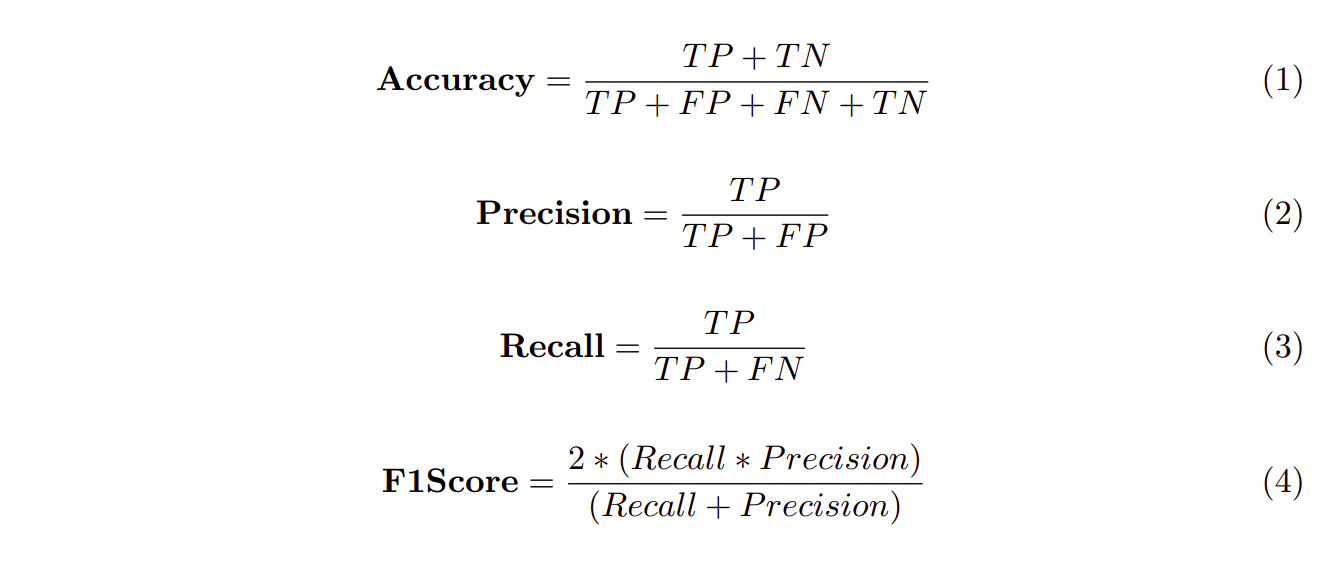

We report these four measurement metrics for your of each test with respect to
5-fold cross validation and finally also write the rules for your best decision tree
model variation with respect to your 5-fold cross validation.

### Error Analysis for Classification <a class="anchor" id="glass1.4"></a>

In [ ]:

dfDiabetes = pd.read_csv("diabetes_data_upload.csv")

npDiabetes = dfDiabetes.to_numpy()
npDiabetes = discreteFeature(npDiabetes, [0], 5)

np.random.shuffle(npDiabetes)
npDiabetes = mapDataFrame(npDiabetes, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])

pdDibates = pd.DataFrame(npDiabetes, columns=dfDiabetes.columns.values)

pdDibates.to_csv("x.csv", index= False)

out = []
csvfile = open("x.csv", 'r')
fileToRead = csv.reader(csvfile)

headers = next(fileToRead)

for row in fileToRead:
    out.append(dict(zip(headers, row)))

kFoldCrossValidationClasification(out)

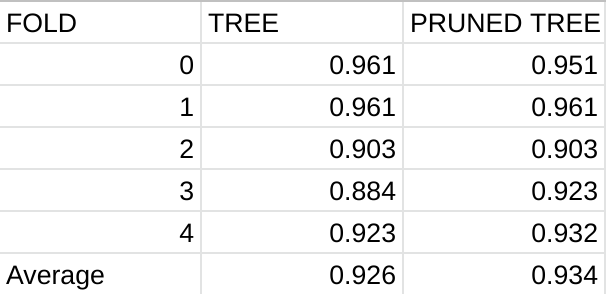

The results in Table 1 were obtained by taking the average of 5 different results obtained from the 5-fold cross-validation method.

Decision trees are unstable. According to the results of the folds in the 5-fold cross validation, even a small change in the data can affect the success rate. In addition, pruning the tree protects us from overfitting in general, while at the same time we do this as a reference for our success rate, so we get a tree with a more general hypothesis with a higher success rate. But due to its nature, the decision trees are not very successful for classification compared to other classification algorithms, which also makes their analysis difficult.
Although we build the tree, the pruning process runs about 6 times slower than the tree build process.
Let's look at two examples where our algorithm guessed wrong:

s1 =[59,Female,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Positive]\
s2 = [59,Female,No,No,No,Yes,No,No,Yes,Yes,No,Yes,No,Yes,Yes,Yes,Negative]\
s3 = [59,Female,No,No,No,Yes,No,No,Yes,Yes,No,Yes,No,Yes,Yes,Yes,Negative]\
s4 = [59,Female,No,No,No,Yes,No,No,Yes,Yes,No,Yes,No,Yes,Yes,Yes,Negative]

Our algorithm predicted s1 as negative. When we examined the reason for this, we saw that the numbers tended to predict the negative class when we made the decision on the tree in our best attributes.

s5 = [44,Male,No,Yes,No,No,No,Yes,No,No,No,Yes,No,No,No,Yes,Positive]

We saw that our algorithm predicts the s5 as negative. When we discrete the age attribute, it maps the 30-44 age range as 2. The fact that the 30-44 age group was generally negative led us to estimate s5 as negative. If we changed our bias value, s5 would be included in a different age range and the result would be correct.

### References <a class="anchor" id="references"></a>

1. Lecture Notes: https://web.cs.hacettepe.edu.tr/~abc/teaching/bbm406/index.php
2. Wikipedia: https://en.wikipedia.org/wiki/Decision_tree#:~:text=Disadvantages%20of%20decision%20trees%3A,perform%20better%20with%20similar%20data.
3. Medium: https://dhirajkumarblog.medium.com/top-5-advantages-and-disadvantages-of-decision-tree-algorithm-428ebd199d9a

**Disclaimer!** <font color='grey'>This notebook was prepared by İsmail Ateş & Mustafa Kollu as a assignment for the *BBM409 : Introduction to Machine Learning Laboratory* class. The notebook is available for educational purposes only. There is no guarantee on the correctness of the content provided as it is a student work.
